In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from tqdm import tqdm
from scipy.optimize import curve_fit

## Exercise 1

In [2]:
np.random.seed(42)
n_sim = 10000                       # number of Monte Carlo simulations
T = 1.0                             # maturity in years
r = 0.02                            # risk-free rate
K = 100                             # strike
S0 = np.array([100, 90, 120])       # initial stock prices
sigma = np.array([0.05, 0.3, 0.8])  # volatilities

# correlation matrix
cov = np.array([
    [1.0, 0.05, 0.65],
    [0.05, 1.0, 0.2],
    [0.65, 0.2, 1.0]
])

# cholesky decomposition to decompose covariance matrix and introduce dependence
L = np.linalg.cholesky(cov)

# simulation of correlated Brownian motions
Z = np.random.normal(size=(n_sim, 3))
W = Z @ L.T  # introduce correlations

# simulation of terminal stock prices (GBM)
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * W)

# calcilation of payoff at time T
X_T = np.maximum.reduce([S_T[:, 0], S_T[:, 1], S_T[:, 2], np.full(n_sim, K)])

# discounted expected payoff
price = np.exp(-r * T) * np.mean(X_T)

print(f"Estimated derivative price: {price:.4f}")

Estimated derivative price: 147.5778


## Exercise 2

In [3]:
class Delta_Hedging:
    def __init__(self, S_0 = 100, K = 100, T = 20/52, r = 0.05, sigma = 0.20, n_options = 100, n_steps = 20):
        self.S_0 = S_0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_options = n_options
        self.n_steps = n_steps
        self.dt = T / n_steps

    def black_scholes_call(self, S, t):
        """ Black-Scholes call price and delta"""
        if t >= self.T:
            price = max(S - self.K, 0)
            delta = 1 if S > self.K else 0
        else:
            tau = self.T - t
            d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau))
            d2 = d1 - self.sigma * np.sqrt(tau)
            price = S * norm.cdf(d1) - self.K * np.exp(-self.r * tau) * norm.cdf(d2)
            delta = norm.cdf(d1)
        return price, delta

    def simulate_path(self, path_volatility = None, ):
        """Simulation of one path and delta hedging strategy"""
        if path_volatility is None:
            path_volatility = self.sigma

        times = np.linspace(0, self.T, self.n_steps + 1)
        S = np.zeros(self.n_steps + 1)
        delta = np.zeros(self.n_steps + 1)
        V_S = np.zeros(self.n_steps + 1)
        V_B = np.zeros(self.n_steps + 1)
        V = np.zeros(self.n_steps + 1)
        C = np.zeros(self.n_steps + 1)
        X = np.zeros(self.n_steps + 1)
        pi = np.zeros(self.n_steps + 1)

        # initial conditions
        S[0] = self.S_0
        C[0], _ = self.black_scholes_call(S[0], times[0])
        C[0] *= self.n_options
        delta[0] = 0   # no position at time 0
        V[0] = C[0]    # initial portfolio value equals option price
        V_B[0] = C[0]  # all in cash initially
        X[0] = C[0] - V[0]
        pi[0] = 0

        # generationg asset price path (as GBM)
        for i in range(1, self.n_steps + 1):
            z = np.random.normal()
            S[i] = S[i - 1] * np.exp((self.r - 0.5 * path_volatility**2) * self.dt +
                                   path_volatility * np.sqrt(self.dt) * z)

        # hedging strategy along the path
        for i in range(1, self.n_steps + 1):
            # calculation of current option price and delta
            C[i], current_delta = self.black_scholes_call(S[i], times[i])
            C[i] *= self.n_options
            current_delta *= self.n_options # delta position of holding 100 stocks

            # previous delta (at tome t_{i - 1})
            prev_delta = delta[i-1]

            # stock component of the portfolio
            V_S[i] = prev_delta * S[i]

            # bond component of portfolio
            V_B[i] = (V[i-1] - prev_delta * S[i-1]) * (1 + self.r * self.dt)

            # total portfolio value
            V[i] = V_S[i] + V_B[i]

            # hedging error
            X[i] = C[i] - V[i]

            # P&L (negative of hedging error)
            pi[i] = -X[i]

            # update delta for next period
            delta[i] = current_delta

        return {
            'times': times,
            'S': S,
            'delta': delta,
            'V_S': V_S,
            'V_B': V_B,
            'V': V,
            'C': C,
            'X': X,
            'pi': pi
        }

    def find_hedging_paths(self, n_simulations=1000):
        """Find paths with positive and negative final P&L"""
        positive_paths = []
        negative_paths = []

        for _ in range(n_simulations):

            result = self.simulate_path(self.sigma) # simulate stock and portfolio path

            final_PnL = result['pi'][-1] # get PnL at final position
            hedging_error = final_PnL / (result['C'][0])

            if final_PnL > 0:
                positive_paths.append((result, hedging_error, final_PnL))
            elif final_PnL < 0:
                negative_paths.append((result, hedging_error, final_PnL))

            if len(positive_paths) >= 3 and len(negative_paths) >= 3:
                break

        return positive_paths, negative_paths

    def print_results(self, results, title):
        print(f"\n{title}")
        print("="*120)
        print(f"{'i':>2} {'t_i':>6} {'S(t_i)':>8} {'Δ(t_{i-1})':>10} {'V_S(t_i)':>12} {'V_B(t_i)':>12} {'V(t_i)':>10} {'C(t_i,S(t_i))':>14} {'X(t_i)':>10} {'Π(t_i)':>10}")
        print("-"*120)

        data = results[0]  # first result for display
        for i in range(len(data['times'])):
            print(f"{i:2d} {data['times'][i]:6.2f} {data['S'][i]:8.2f} {data['delta'][i]:10.2f} "
                  f"{data['V_S'][i]:12.2f} {data['V_B'][i]:12.2f} {data['V'][i]:10.2f} "
                  f"{data['C'][i]:14.2f} {data['X'][i]:10.2f} {data['pi'][i]:10.2f}")

        print(f"\nFinal P&L: {results[2]:.2f}")
        print(f"Hedging Error (π): {results[1]:.4f}")


In [4]:
# run the simulation
simulator = Delta_Hedging()

# get paths with positive and negative P&L
positive_paths, negative_paths = simulator.find_hedging_paths(n_simulations=2000)


In [5]:
# resilt for the simulation of positibe PnL
if positive_paths:
    simulator.print_results(positive_paths[0], "DELTA HEDGING STRATEGY (POSITIVE P&L)")


DELTA HEDGING STRATEGY (POSITIVE P&L)
 i    t_i   S(t_i) Δ(t_{i-1})     V_S(t_i)     V_B(t_i)     V(t_i)  C(t_i,S(t_i))     X(t_i)     Π(t_i)
------------------------------------------------------------------------------------------------------------------------
 0   0.00   100.00       0.00         0.00       590.90     590.90         590.90       0.00       0.00
 1   0.02    94.71      40.59         0.00       591.47     591.47         311.42    -280.05     280.05
 2   0.04    92.03      30.86      3735.80     -3256.17     479.64         201.61    -278.03     278.03
 3   0.06    90.60      25.36      2796.04     -2362.93     433.11         148.82    -284.29     284.29
 4   0.08    91.03      25.68      2308.02     -1865.81     442.21         147.73    -294.47     294.47
 5   0.10    93.70      33.82      2406.19     -1897.07     509.12         213.38    -295.74     295.74
 6   0.12    95.58      39.98      3232.35     -2662.33     570.02         266.42    -303.61     303.61
 7   0.1

In [6]:
# resilt for the simulation of negative PnL
if negative_paths:
    simulator.print_results(negative_paths[0], "DELTA HEDGING STRATEGY (NEGATIVE P&L)")


DELTA HEDGING STRATEGY (NEGATIVE P&L)
 i    t_i   S(t_i) Δ(t_{i-1})     V_S(t_i)     V_B(t_i)     V(t_i)  C(t_i,S(t_i))     X(t_i)     Π(t_i)
------------------------------------------------------------------------------------------------------------------------
 0   0.00   100.00       0.00         0.00       590.90     590.90         590.90       0.00       0.00
 1   0.02   102.87      67.22         0.00       591.47     591.47         754.25     162.77    -162.77
 2   0.04   105.08      73.46      7062.78     -6329.31     733.47         891.46     157.98    -157.98
 3   0.06   104.24      71.34      7657.28     -6991.97     665.31         812.83     147.51    -147.51
 4   0.08   103.09      68.02      7353.87     -6777.30     576.57         713.89     137.33    -137.33
 5   0.10   106.33      77.63      7232.61     -6441.40     791.21         931.98     140.77    -140.77
 6   0.12   107.08      79.98      8312.59     -7470.47     842.12         972.52     130.40    -130.40
 7   0.1

In [7]:
# b)
def analyze_hedging_errors(n_simulations = 10_000, T = 0.5, S_0 = 100, K = 100, r  =0.05, sigma = 0.2, n_options = 100):
    """PDF of hedging errors for different rebalancing frequencies"""
    # dt values in trading days (step sizes)
    dt_values = {
        'dt = 26': 26,    # rebalance every 26 days
        'dt = 13': 13,    # rebalance every 13 days
        'dt = 10': 10,    # rebalance every 10 days
        'dt = 5': 5,      # rebalance every 5 days
        'dt = 2': 2,      # rebalance every 2 days
        'dt = 1': 1       # daily rebalancing
    }

    results = {}

    for freq_name, dt_days in dt_values.items():
        # number of steps based on dt and total time (130 days)
        n_steps = int(130 / dt_days)  # 130 trading days total

        print(f"Simulating {freq_name} rebalancing ({n_steps} steps, dt={dt_days} days)...")

        hedging_sim = Delta_Hedging(
            S_0 = S_0,
            K = K,
            T = T,  # 0.5 years for 130 trading days
            r = r,
            sigma = sigma,
            n_options = n_options,
            n_steps = n_steps
        )

        hedging_errors = []

        for _ in tqdm(range(n_simulations)):
            result = hedging_sim.simulate_path()
            final_PnL = result['pi'][-1]
            initial_option_price = result['C'][0]
            hedging_error = final_PnL / initial_option_price
            hedging_errors.append(hedging_error)

        results[freq_name] = np.array(hedging_errors)

        # statistics
        print(f"  Mean π: {np.mean(hedging_errors):.6f}")
        print(f"  Std π: {np.std(hedging_errors):.6f}")
        print(f"  Variance: {np.var(hedging_errors):.6f}")
        print()

    return results

def plot_pdf_comparison(results, T = 0.5, sigma = 0.2, n_options = 100):
    """PDF for different rebalancing frequencies"""
    plt.figure(figsize=(12, 8))

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    linestyles = ['-', '--', '-.', ':', '-', '--']

    for i, (freq_name, hedging_errors) in enumerate(results.items()):
        # kernel density estimation for smooth PDF
        kde = gaussian_kde(hedging_errors)
        x_range = np.linspace(np.min(hedging_errors), np.max(hedging_errors), 1000)
        pdf_values = kde(x_range)

        plt.plot(x_range, pdf_values,
                label=f'{freq_name}',
                color=colors[i % len(colors)],
                linestyle=linestyles[i % len(linestyles)],
                linewidth=2)

    plt.xlabel('Hedging Error Ratio', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title('Probability Density Function of Hedging Error Ratio\n'
             'for Different Rebalancing Frequencies\n'
             f'(T = {T} years, sigma = {sigma}, {n_options} options)',
             fontsize=13)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    all_errors = np.concatenate(list(results.values()))
    x_min, x_max = np.percentile(all_errors, [1, 99])
    plt.xlim(x_min, x_max)

    plt.tight_layout()
    plt.show()

Simulating dt = 26 rebalancing (5 steps, dt=26 days)...


100%|██████████| 10000/10000 [00:27<00:00, 362.81it/s]


  Mean π: -0.011164
  Std π: 0.645568
  Variance: 0.416758

Simulating dt = 13 rebalancing (10 steps, dt=13 days)...


100%|██████████| 10000/10000 [00:33<00:00, 302.13it/s]


  Mean π: 0.000638
  Std π: 0.456538
  Variance: 0.208427

Simulating dt = 10 rebalancing (13 steps, dt=10 days)...


100%|██████████| 10000/10000 [00:41<00:00, 239.77it/s]


  Mean π: -0.006549
  Std π: 0.403616
  Variance: 0.162906

Simulating dt = 5 rebalancing (26 steps, dt=5 days)...


100%|██████████| 10000/10000 [01:25<00:00, 117.53it/s]


  Mean π: -0.003353
  Std π: 0.284238
  Variance: 0.080791

Simulating dt = 2 rebalancing (65 steps, dt=2 days)...


100%|██████████| 10000/10000 [03:26<00:00, 48.50it/s]


  Mean π: -0.002441
  Std π: 0.178542
  Variance: 0.031877

Simulating dt = 1 rebalancing (130 steps, dt=1 days)...


100%|██████████| 10000/10000 [06:48<00:00, 24.49it/s]


  Mean π: -0.000235
  Std π: 0.126394
  Variance: 0.015975



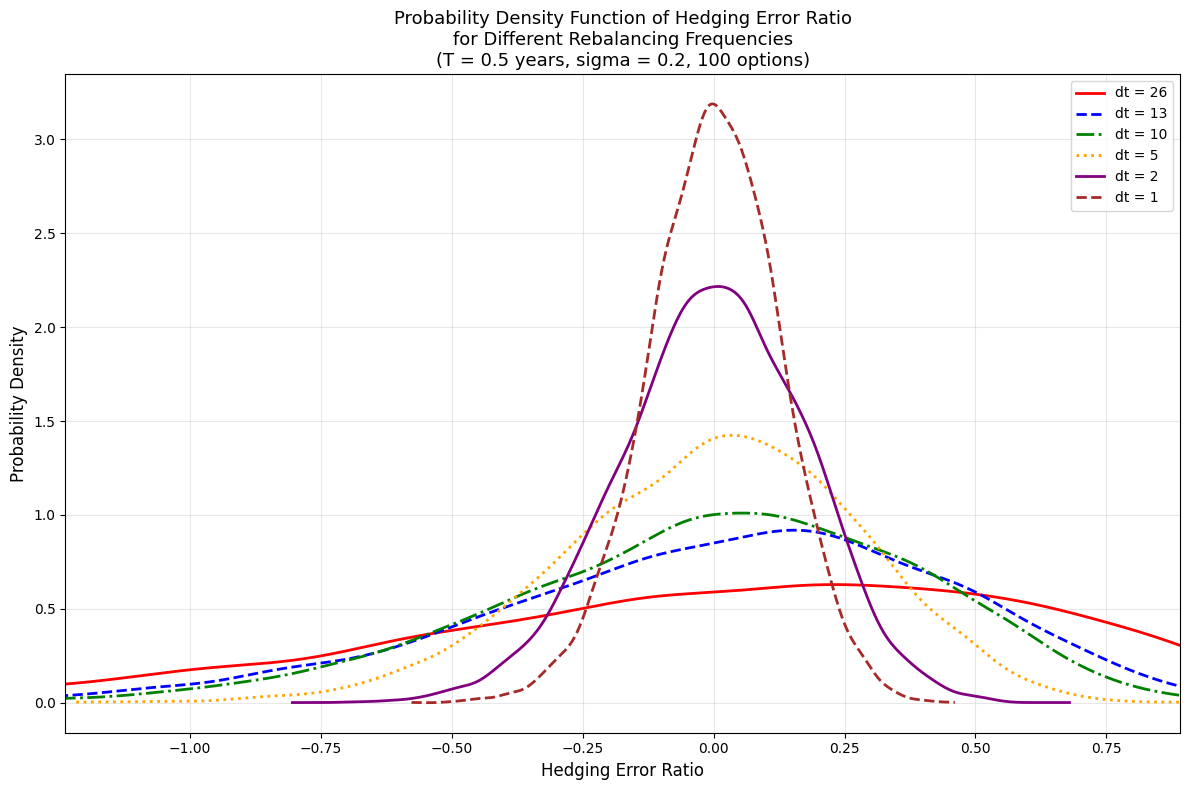

In [8]:
# hedging error analysis
results = analyze_hedging_errors(
        n_simulations = 10000,
        T = 0.5,
        S_0 = 100,
        K = 100,
        r = 0.05,
        sigma = 0.2,
        n_options = 100
    )

# PDF comparison
plot_pdf_comparison(results, T = 0.5, sigma = 0.20, n_options = 100)

The results show the more frequent rebalancing is the less hedging error becomes (reduced variance), thus, replication quality with frequent rebalancing is better.

In [9]:
# c)

def analyze_hedging_volatility_mismatch(n_simulations = 10_000, T = 0.5, S_0 = 100, K = 100, r = 0.05,
                                      implied_vol = 0.2, n_options = 100, dt_days = 5):
    """Hedging errors for different volatilities"""

    # different scenarios: hedging_vol vs realized_vol
    volatility_scenarios = {
        'sigma_hedge = 15%, sigma_real = 20%': {'hedge_vol': 0.15, 'real_vol': 0.2},
        'sigma_hedge = 20%, sigma_real = 20%': {'hedge_vol': 0.2, 'real_vol': 0.2},  # Baseline
        'sigma_hedge = 25%, sigma_real = 20%': {'hedge_vol': 0.25, 'real_vol': 0.2},
        'sigma_hedge = 20%, sigma_real = 15%': {'hedge_vol': 0.2, 'real_vol': 0.15},
        'sigma_hedge = 20%, sigma_real = 25%': {'hedge_vol': 0.2, 'real_vol': 0.25},
    }

    results = {}

    # fixed rebalancing frequency
    n_steps = int(130 / dt_days)  # 130 trading days total

    for scenario_name, vol_params in volatility_scenarios.items():
        hedge_vol = vol_params['hedge_vol']
        real_vol = vol_params['real_vol']

        print(f"Simulating {scenario_name} (dt={dt_days} days, {n_steps} steps)...")

        # hedging simulator with hedging volatility
        hedging_sim = Delta_Hedging(
            S_0 = S_0,
            K = K,
            T = T,
            r = r,
            sigma = hedge_vol,  # hedging vol for delta calculation
            n_options = n_options,
            n_steps = n_steps
        )

        hedging_errors = []
        final_PnLs = []

        for _ in tqdm(range(n_simulations)):
            # simulate path with realized volatility but hedge with implied volatility to create volatility "mismatches"
            result = hedging_sim.simulate_path(path_volatility=real_vol)
            final_PnL = result['pi'][-1]
            initial_option_price = result['C'][0]
            hedging_error = final_PnL / initial_option_price
            hedging_errors.append(hedging_error)
            final_PnLs.append(final_PnL)

        results[scenario_name] = {
            'hedging_errors': np.array(hedging_errors),
            'final_PnLs': np.array(final_PnLs),
            'mean_error': np.mean(hedging_errors),
            'std_error': np.std(hedging_errors),
            'variance': np.var(hedging_errors),
            'mean_PnL': np.mean(final_PnLs)
        }

        # statistics
        print(f"  Mean π: {results[scenario_name]['mean_error']:.6f}")
        print(f"  Std π: {results[scenario_name]['std_error']:.6f}")
        print(f"  Variance: {results[scenario_name]['variance']:.6f}")
        print(f"  Mean P&L: {results[scenario_name]['mean_PnL']:.2f}")
        print()

    return results

def plot_volatility_mismatch_pdf(results, T = 0.5, n_options = 100, dt_days = 5):
    """Plot PDF comparison for different volatility mismatch scenarios"""
    plt.figure(figsize=(12, 8))

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    linestyles = ['-', '--', '-.', ':', '-', '--']

    for i, (scenario_name, scenario_data) in enumerate(results.items()):
        hedging_errors = scenario_data['hedging_errors']

        # kernel density estimation for smooth PDF
        kde = gaussian_kde(hedging_errors)
        x_range = np.linspace(np.min(hedging_errors), np.max(hedging_errors), 1000)
        pdf_values = kde(x_range)

        plt.plot(x_range, pdf_values,
                label=f'{scenario_name}',
                color=colors[i % len(colors)],
                linestyle=linestyles[i % len(linestyles)],
                linewidth=2)

    plt.xlabel('Hedging Error Ratio', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title('PDF of Hedging Error: Volatility Mismatch Analysis\n'
             f'(T = {T} years, {n_options} options, dt = {dt_days} days)',
             fontsize=13)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

    all_errors = np.concatenate([data['hedging_errors'] for data in results.values()])
    x_min, x_max = np.percentile(all_errors, [1, 99])
    plt.xlim(x_min, x_max)

    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()


Simulating sigma_hedge = 15%, sigma_real = 20% (dt=5 days, 26 steps)...


100%|██████████| 10000/10000 [01:31<00:00, 108.76it/s]


  Mean π: -0.250470
  Std π: 0.371114
  Variance: 0.137726
  Mean P&L: -138.44

Simulating sigma_hedge = 20%, sigma_real = 20% (dt=5 days, 26 steps)...


100%|██████████| 10000/10000 [01:24<00:00, 118.61it/s]


  Mean π: 0.005818
  Std π: 0.284391
  Variance: 0.080879
  Mean P&L: 4.01

Simulating sigma_hedge = 25%, sigma_real = 20% (dt=5 days, 26 steps)...


100%|██████████| 10000/10000 [01:23<00:00, 119.44it/s]


  Mean π: 0.172182
  Std π: 0.236787
  Variance: 0.056068
  Mean P&L: 142.22

Simulating sigma_hedge = 20%, sigma_real = 15% (dt=5 days, 26 steps)...


100%|██████████| 10000/10000 [01:22<00:00, 120.76it/s]


  Mean π: 0.200447
  Std π: 0.225352
  Variance: 0.050783
  Mean P&L: 138.08

Simulating sigma_hedge = 20%, sigma_real = 25% (dt=5 days, 26 steps)...


100%|██████████| 10000/10000 [01:23<00:00, 119.56it/s]


  Mean π: -0.205062
  Std π: 0.362390
  Variance: 0.131326
  Mean P&L: -141.26



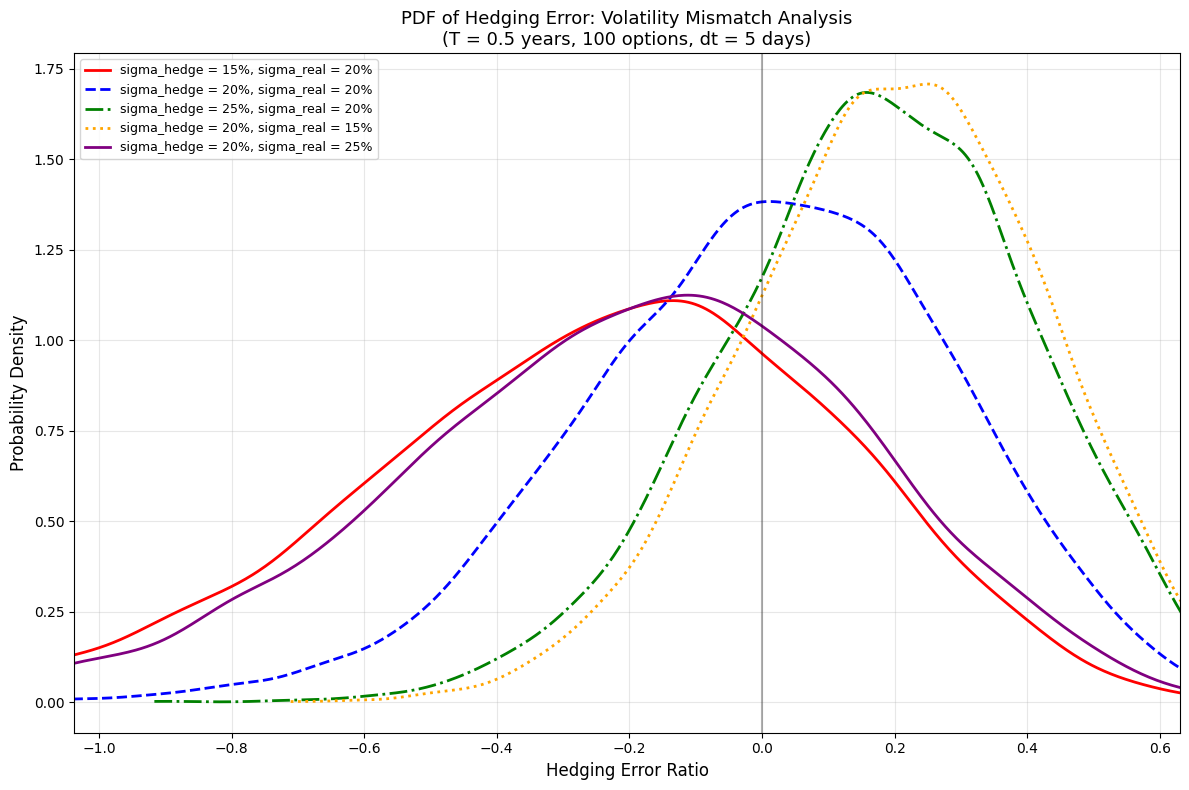

In [10]:
# analysis for volatility
results = analyze_hedging_volatility_mismatch(
        n_simulations = 10000,
        T = 0.5,
        S_0 = 100,
        K = 100,
        r = 0.05,
        implied_vol = 0.2,
        n_options = 100,
        dt_days = 5)

# PDF comparison
plot_volatility_mismatch_pdf(results, T=0.5, n_options=100, dt_days=5)

In [11]:
# d)
def calculate_hedging_efficiency(n_simulations = 5000, T = 130/260, S_0 = 100, K = 100, r = 0.05, sigma = 0.20, n_options = 100):
    """Hedging efficiency for different rebalancing frequencies"""

    # dt values (rebalancing frequencies in days)
    dt_values_days = [26, 13, 10, 5, 2, 1]  # days between rebalancing
    dt_values_years = [dt/260 for dt in dt_values_days]  # in years

    efficiency_results = []

    for dt_days in dt_values_days:
        n_steps = int(130 / dt_days)

        print(f"Analyzing dt = {dt_days} days ({n_steps} steps)...")

        hedging_sim = Delta_Hedging(
            S_0 = S_0, K = K, T = T, r = r, sigma = sigma,
            n_options = n_options, n_steps = n_steps
        )

        hedging_errors = []

        for _ in tqdm(range(n_simulations)):
            result = hedging_sim.simulate_path()
            final_PnL = result['pi'][-1]
            initial_option_price = result['C'][0]
            hedging_error = final_PnL / initial_option_price
            hedging_errors.append(hedging_error)

        hedging_errors = np.array(hedging_errors)

        # efficiency measures
        variance = np.var(hedging_errors)
        std = np.std(hedging_errors)

        efficiency_results.append({
            'dt_days': dt_days,
            'dt_years': dt_days/260,
            'n_steps': n_steps,
            'variance': variance,
            'std': std,
            'hedging_errors': hedging_errors
        })

        print(f"  Variance: {variance:.6f}")
        print(f"  Std: {std:.6f}")
        print()

    return efficiency_results

def plot_efficiency_vs_frequency(efficiency_results):
    """Hedging efficiency vs rebalancing frequency"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # extract data
    dt_days = [result['dt_days'] for result in efficiency_results]
    variances = [result['variance'] for result in efficiency_results]
    stds = [result['std'] for result in efficiency_results]

    # 1. variance vs dt
    ax1.plot(dt_days, variances, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Rebalancing Interval (dt in days)', fontsize=12)
    ax1.set_ylabel('Variance of Hedging Error', fontsize=12)
    ax1.set_title('Variance vs Rebalancing Interval', fontsize=13)
    ax1.grid(True, alpha=0.3)

    # 2. standard Deviation vs dt
    ax2.plot(dt_days, stds, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Rebalancing Interval (dt in days)', fontsize=12)
    ax2.set_ylabel('Standard Deviation of Hedging Error', fontsize=12)
    ax2.set_title('Standard Deviation vs Rebalancing Interval', fontsize=13)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

Analyzing dt = 26 days (5 steps)...


100%|██████████| 5000/5000 [00:08<00:00, 573.27it/s]


  Variance: 0.413120
  Std: 0.642744

Analyzing dt = 13 days (10 steps)...


100%|██████████| 5000/5000 [00:15<00:00, 314.18it/s]


  Variance: 0.203645
  Std: 0.451270

Analyzing dt = 10 days (13 steps)...


100%|██████████| 5000/5000 [00:21<00:00, 232.79it/s]


  Variance: 0.162759
  Std: 0.403434

Analyzing dt = 5 days (26 steps)...


100%|██████████| 5000/5000 [00:41<00:00, 120.89it/s]


  Variance: 0.080521
  Std: 0.283762

Analyzing dt = 2 days (65 steps)...


100%|██████████| 5000/5000 [01:42<00:00, 48.56it/s]


  Variance: 0.031830
  Std: 0.178410

Analyzing dt = 1 days (130 steps)...


100%|██████████| 5000/5000 [03:25<00:00, 24.37it/s]


  Variance: 0.016376
  Std: 0.127968



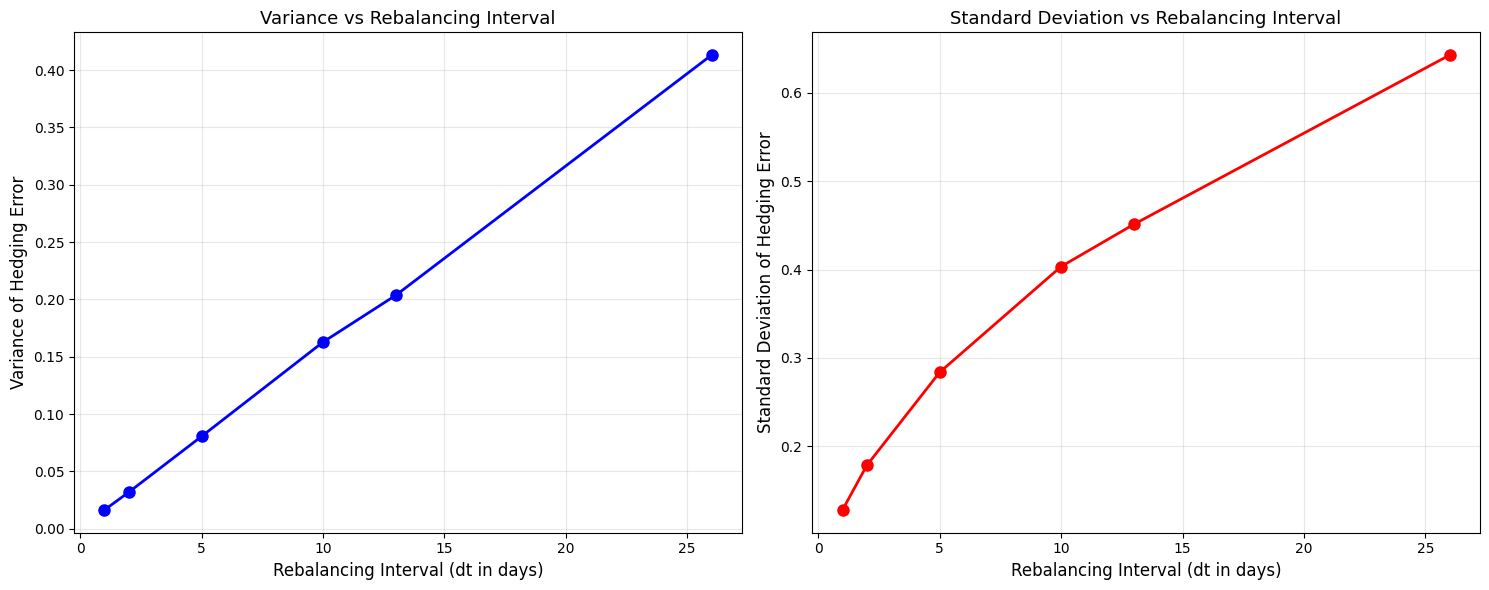

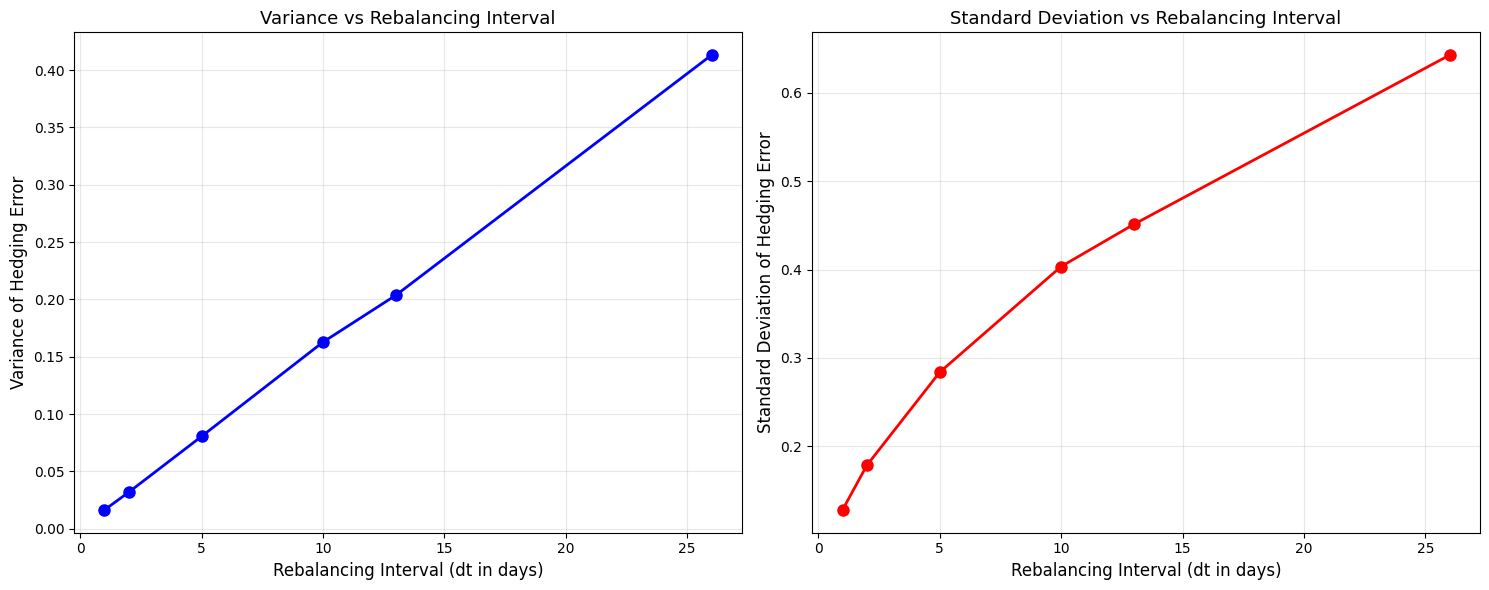

In [12]:
# efficiency for different frequencies
efficiency_results = calculate_hedging_efficiency(n_simulations = 5000)

# Plot relationships
plot_efficiency_vs_frequency(efficiency_results)

## Exercise 3


### 3.1

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
import pandas as pd

In [14]:
class Price_sim:

    def __init__(self, S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000):

        self.S_0 = S_0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.time = np.linspace(0, T, T+1)
        self.n_sim = n_sim
        self.dt = 1

    def price_sim(self):

        np.random.seed(42)
        Z = np.random.standard_normal((self.n_sim, self.T + 1))
        W_t = np.cumsum(np.sqrt(self.dt) * Z, axis=1)

        S_t = self.S_0 * np.exp((self.r - 0.5 * self.sigma**2) * self.time + self.sigma * W_t)
        return S_t

    def payoff_sim(self, S_t):

        # 1
        terminal_price = S_t[:, -1]

        # 2
        avg = np.mean(S_t, axis=1)

        asian_call = np.maximum(avg - self.K, 0) * np.exp(-self.r * self.T)

        # 3
        european_call = np.maximum(terminal_price - self.K, 0) * np.exp(-self.r * self.T)

        # 4
        geom_avg = np.exp(np.mean(np.log(S_t), axis=1))
        geometric_asian_call = np.maximum(geom_avg - self.K, 0) * np.exp(-self.r * self.T)

        exp_terminal_price = self.S_0 * np.exp(self.r * self.T)
        exp_avr = self.S_0 / self.T * np.sum(np.exp(self.r * self.time))
        exp_european_call =  self.euro_call()
        exp_geometric_asian_call = self.geometric_asian()

        return asian_call, terminal_price, avg, european_call, geometric_asian_call, exp_terminal_price, exp_avr, exp_european_call, exp_geometric_asian_call

    def euro_call(self):

        d1 = (np.log(self.S_0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        return self.S_0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)

    def geometric_asian(self):

        v = self.compute_var()
        t_hat = np.mean(np.linspace(1, self.T, self.T))
        d = (1/self.sigma * np.sqrt(v)) * (np.log(self.S_0 / self.K) + (self.r - 0.5 * self.sigma**2) * t_hat)
        gamma = self.r * t_hat + 0.5 * self.sigma**2 * (v - t_hat)

        return self.S_0 * np.exp(gamma - self.r * self.T) * norm.cdf(d + self.sigma * np.sqrt(v)) - self.K * np.exp(-self.r * self.T) * norm.cdf(d)

    def compute_var(self):

        n = self.T
        cov_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(n):
                # cov(W(t_i), W(t_j)) = min(t_i, t_j)
                cov_matrix[i, j] = min(self.time[i], self.time[j])

        v = np.sum(cov_matrix) * (1/n) ** 2

        return v

    def control_variate_estimator(self, Y, X, expected_X):

        beta = np.cov(X, Y)[0][1] / np.var(X)
        Y_cv = Y - beta * (X - expected_X)

        return Y_cv.mean(), beta, Y_cv

In [15]:
S_t = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).price_sim()

In [16]:
asian_call = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[0]
terminal_price = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[1]
avg = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[2]
european_call = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[3]
geometric_asian_call = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[4]
exp_terminal_price = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[5]
exp_avr = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[6]
exp_european_call = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[7]
exp_geometric_asian_call = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).payoff_sim(S_t)[8]

/tmp/ipython-input-1348963582.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[0].plot(x, pdf_mc(x), 'b-', linewidth=2, label='MC Estimator', color = 'blue')
/tmp/ipython-input-1348963582.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[0].plot(x, pdf_1(x), 'b-', linewidth=2, label='CV-1', color = 'green')
/tmp/ipython-input-1348963582.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[1].plot(x, pdf_mc(x), 'b-', linewidth=2, label='MC Estimator', color = 'blue')
/tmp/ipython-input-1348963582.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argum

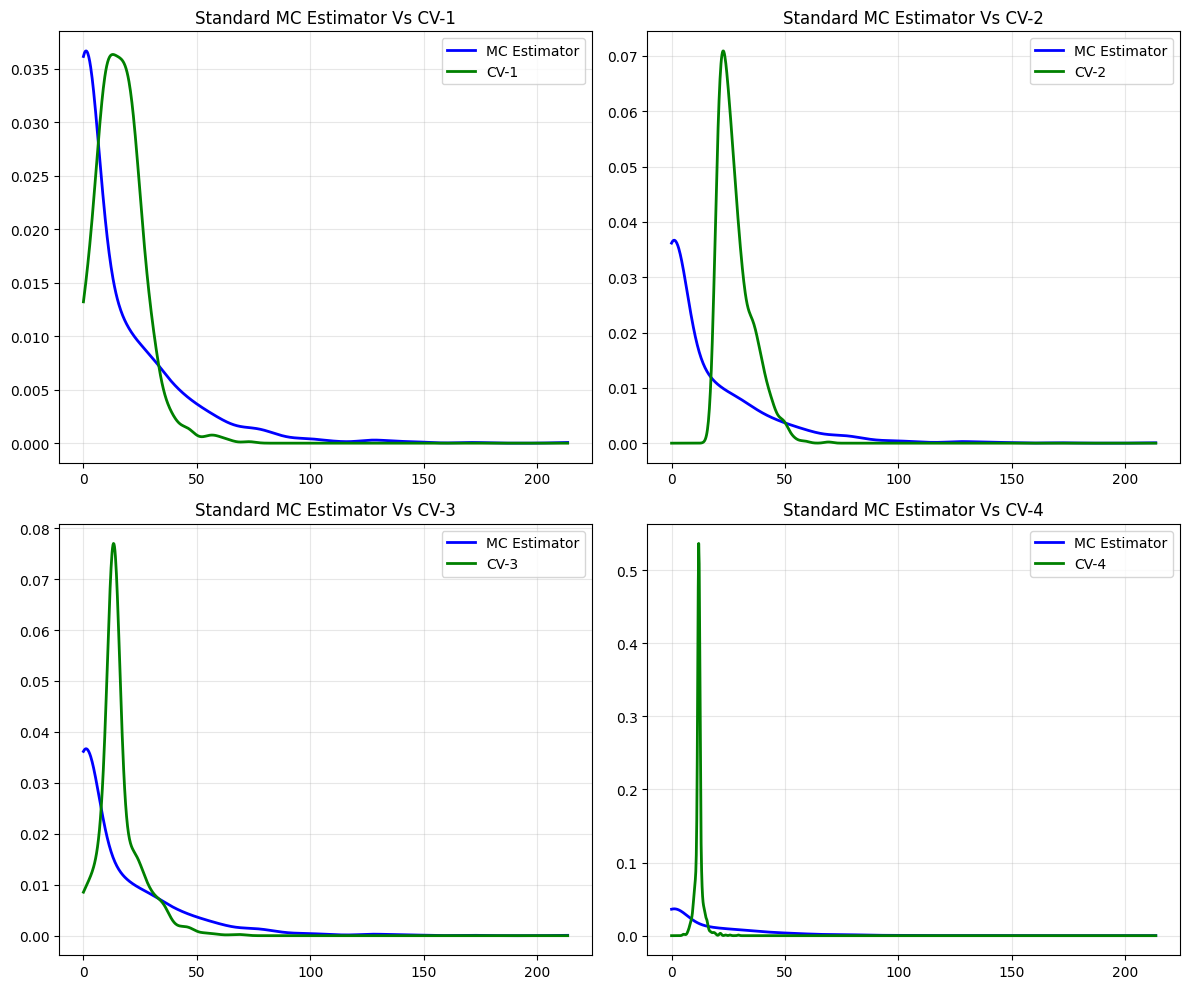

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

x = np.linspace(np.min(asian_call), np.max(asian_call), 1000)
pdf_mc = gaussian_kde(asian_call)
pdf_1 = gaussian_kde(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, terminal_price, exp_terminal_price)[2])
pdf_2 = gaussian_kde(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, avg, exp_avr)[2])
pdf_3 = gaussian_kde(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, european_call, exp_european_call)[2])
pdf_4 = gaussian_kde(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, geometric_asian_call, exp_geometric_asian_call)[2])

axes[0].plot(x, pdf_mc(x), 'b-', linewidth=2, label='MC Estimator', color = 'blue')
axes[0].plot(x, pdf_1(x), 'b-', linewidth=2, label='CV-1', color = 'green')
axes[0].set_title('Standard MC Estimator Vs CV-1')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, pdf_mc(x), 'b-', linewidth=2, label='MC Estimator', color = 'blue')
axes[1].plot(x, pdf_2(x), 'b-', linewidth=2, label='CV-2', color = 'green')
axes[1].set_title('Standard MC Estimator Vs CV-2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(x, pdf_mc(x), 'b-', linewidth=2, label='MC Estimator', color = 'blue')
axes[2].plot(x, pdf_3(x), 'b-', linewidth=2, label='CV-3', color = 'green')
axes[2].set_title('Standard MC Estimator Vs CV-3')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].plot(x, pdf_mc(x), 'b-', linewidth=2, label='MC Estimator', color = 'blue')
axes[3].plot(x, pdf_4(x), 'b-', linewidth=2, label='CV-4', color = 'green')
axes[3].set_title('Standard MC Estimator Vs CV-4')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2

In [18]:
var_1 = np.var(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, terminal_price, exp_terminal_price)[2])
var_2 = np.var(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, avg, exp_avr)[2])
var_3 = np.var(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, european_call, exp_european_call)[2])
var_4 = np.var(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, geometric_asian_call, exp_geometric_asian_call)[2])
var = np.var(asian_call)

In [19]:
var_1/var

np.float64(0.21923225999245416)

In [20]:
var_2/var

np.float64(0.095525022940059)

In [21]:
var_3/var

np.float64(0.1832506239828127)

In [22]:
var_4/var

np.float64(0.005427526485181978)

### 3.3

In [23]:
weights = []
w = []
i = 0
for a in np.arange(0.1, 1, 0.1):
  for b in np.arange(0.1, 1-a, 0.1):
    for c in np.arange(0.1, 1-a-b, 0.1):
      for d in np.arange(0.1, 1-a-b-c, 0.1):
        weights.append(np.array([a, b, c, d]))
for i in range(0, len(weights)):
  if int(np.sum(weights[i])) == 1:
    w.append(weights[i])

lin_reg_coef = []
var_rat = []


for i in w:
  var_cv = np.var(Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, i[0]*terminal_price + i[1]*avg + i[2]*european_call + i[3]*geometric_asian_call, i[0]*exp_terminal_price + i[1]*exp_avr + i[2]*exp_european_call + i[3]*exp_geometric_asian_call)[2])
  coef = Price_sim(S_0=100, K=104, r=0.05, sigma=0.2, T=5, n_sim=1000).control_variate_estimator(asian_call, i[0]*terminal_price + i[1]*avg + i[2]*european_call + i[3]*geometric_asian_call, i[0]*exp_terminal_price + i[1]*exp_avr + i[2]*exp_european_call + i[3]*exp_geometric_asian_call)[1]
  lin_reg_coef.append(coef)
  var_rat.append(var_cv/var)

df = pd.DataFrame()
df['weights'] = w
df['linear regression coefficients'] = lin_reg_coef
df['variance ratio'] = var_rat
df

,weights,linear regression coefficients,variance ratio
0,"[0.1, 0.1, 0.1, 0.7000000000000001]",0.815997,0.028194
1,"[0.1, 0.1, 0.2, 0.6]",0.754657,0.044408
2,"[0.1, 0.1, 0.4, 0.4]",0.647052,0.083196
3,"[0.1, 0.1, 0.5, 0.30000000000000004]",0.600929,0.103288
4,"[0.1, 0.1, 0.6, 0.2]",0.559518,0.122941
5,"[0.1, 0.4, 0.1, 0.4]",0.690959,0.050447
6,"[0.1, 0.5, 0.1, 0.30000000000000004]",0.655349,0.059340
7,"[0.1, 0.6, 0.1, 0.2]",0.622502,0.068450
8,"[0.2, 0.1, 0.1, 0.6]",0.702276,0.057422
9,"[0.2, 0.1, 0.30000000000000004, 0.4]",0.607831,0.092625
